In [1]:
import gym
gym.logger.set_level(40)

import random
import numpy as np
from collections import deque

import torch

from IPython import display
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from ddpg import DDPGAgent
from model import Actor, Critic

import slimevolleygym
env = gym.make("SlimeVolley-v0")

In [2]:
o_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
print('State shape: ', o_dim)
print('Action shape: ', a_dim)

State shape:  12
Action shape:  3


In [4]:
# agent parameters
LR_ACTOR = 1e-4         # actor learning rate
LR_CRITIC = 1e-4        # critic learning rate
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
BUFFER_SIZE = int(1e6)  # replay buffer size     

agent = DDPGAgent(Actor, Critic, o_dim, a_dim, 128, initialize_weights = True,
                  lr_actor = LR_ACTOR, lr_critic = LR_CRITIC,
                  batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, buffer_size = BUFFER_SIZE,
                  seed = 1234)

print(agent.actor)
print(agent.critic)
print(agent.loss_fn)
print(agent.initialize_weights)

Actor(
  (main): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Tanh()
  )
)
Critic(
  (obs_fc): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): Linear(in_features=131, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SmoothL1Loss()
True


In [6]:
# parameters for training
NUM_EPISODES = 800
PRINT_EVERY = 50
TMAX = 500

eps_start = 1.0
eps_end = 0.1
eps_decay = 0.99

In [7]:
score_list = []
score_window = deque(maxlen = PRINT_EVERY)  
best_score = 0.0

eps = eps_start

In [8]:
for e in range(1, NUM_EPISODES+1):
    state = env.reset() # reset environment
    agent.reset() # reset noise process
    score = 0
    for t in range(TMAX):
        action = agent.get_action2(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        
        if mean_score >= best_score:
            print('\nmodel saved!')
            torch.save(agent.actor.state_dict(), 'checkpoint.pth')
            best_score = mean_score


Episode 50	sum of rewards    -3.56
Episode 100	sum of rewards    -3.70
Episode 150	sum of rewards    -3.60
Episode 200	sum of rewards    -3.66
Episode 250	sum of rewards    -3.50
Episode 300	sum of rewards    -3.74
Episode 350	sum of rewards    -3.58
Episode 400	sum of rewards    -3.36
Episode 450	sum of rewards    -3.28
Episode 500	sum of rewards    -3.40
Episode 550	sum of rewards    -3.60
Episode 600	sum of rewards    -3.58
Episode 650	sum of rewards    -3.50
Episode 700	sum of rewards    -3.24
Episode 750	sum of rewards    -3.58
Episode 800	sum of rewards    -3.28


In [12]:
agent.actor_optimizer = torch.optim.Adam(agent.actor.parameters(), lr = 1e-5)
agent.critic_optimizer = torch.optim.Adam(agent.critic.parameters(), lr = 1e-5)

In [13]:
for e in range(1, NUM_EPISODES+1):
    state = env.reset() # reset environment
    agent.reset() # reset noise process
    score = 0
    for t in range(TMAX):
        action = agent.get_action2(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        
        if mean_score >= best_score:
            print('\nmodel saved!')
            torch.save(agent.actor.state_dict(), 'checkpoint.pth')
            best_score = mean_score

Episode 50	sum of rewards    -3.40
Episode 100	sum of rewards    -3.22
Episode 150	sum of rewards    -3.12
Episode 200	sum of rewards    -2.96
Episode 250	sum of rewards    -3.18
Episode 300	sum of rewards    -3.26
Episode 350	sum of rewards    -3.44
Episode 400	sum of rewards    -3.12
Episode 450	sum of rewards    -3.52
Episode 500	sum of rewards    -3.32
Episode 550	sum of rewards    -2.70
Episode 600	sum of rewards    -3.30
Episode 650	sum of rewards    -3.06
Episode 700	sum of rewards    -3.20
Episode 750	sum of rewards    -3.10
Episode 800	sum of rewards    -3.16


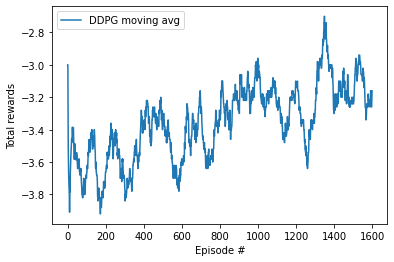

In [16]:
score1 = np.asarray(score_list).T

fig = plt.figure()
#plt.plot(np.arange(score1.shape[1]), score1[0], label = "DDPG")
plt.plot(np.arange(score1.shape[1]), score1[1], label = "DDPG moving avg")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [18]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, '../video', force=True)
    return env

env = wrap_env(gym.make("SlimeVolley-v0"))

state = env.reset()
while True:
    action = agent.get_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break


env.close()

In [17]:
torch.save(agent.actor.cpu().state_dict(), "ddpg_slimevolly.pth")